In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

### References
- Keras tutorial: https://keras.io/examples/vision/super_resolution_sub_pixel/
- LearnOpenCV tutorial: https://learnopencv.com/super-resolution-in-opencv/

In [2]:
def add_zoom(img, ax):
    """
    Add zoom to plot
    """
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False),plt.xticks(visible=False)
    return axins

def plot_results(img1, img2, figure_title=None):
    """
    Create plot to compare the super-resolved and the original frame

    Arguments:
        img1 (numpy array): right image
        img2 (numpy array): left image
        figure_title (str): optional title name for the plot
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 6), dpi = 200)
    plt.tight_layout() # remove white space in plot
    if figure_title is not None:
        fig.suptitle(figure_title, fontsize=22)

    ax1.imshow(img1[::-1], origin="lower"), ax1.set_title('Original', fontsize=18)
    ax2.imshow(img2[::-1], origin="lower"), ax2.set_title('High Resolution', fontsize=18)

    axins_1 = add_zoom(img1, ax1)
    axins_2 = add_zoom(img2, ax2)

    # Make the line.
    mark_inset(ax1, axins_1, loc1=1, loc2=3, fc="none", ec="blue")
    mark_inset(ax2, axins_2, loc1=1, loc2=3, fc="none", ec="blue")
    # plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

In [3]:
# 1010 frames --> go until frame 941
original_video_path = 'videos/Chrono Cross original version.mp4'

# 1001 frames --> start from frame 60, 941 frames left
remaster_video_path = 'videos/Chrono Cross remastered version.mp4'

SCALE = 2

In [4]:
def start_dnn_superres(scale):
    """
    Start opencv dnn model
    Arguments:
        scale (int): scale factor
    Returns:
        sr: opencv super-resolution dnn model
    """
    sr = cv.dnn_superres.DnnSuperResImpl_create()
    path = "models/ESPCN_x{}.pb".format(str(scale))
    sr.readModel(path)
    sr.setModel("espcn",scale)
    return sr

def get_quality_values(orig, upsampled):
    """
    Get psnr and ssim metric values from image comparison
    Arguments:
        orig (numpy array): original image
        upsampled (numpy array): upsampled image
    Returns:
        psnr (float): psnr value
        ssim (float): ssim value
    """
    psnr = cv.PSNR(upsampled, orig)    
    ssim = compare_ssim(upsampled, orig, multichannel=True)
    # print("PSNR: {}, SSIM: {}".format(psnr, ssim))
    return (psnr, ssim)

sr = start_dnn_superres(SCALE)
video_h, video_w = 600, 800

In [5]:
def test_super_resolution(video1, video2=None, test_video=False, learning_based_model='ESPCN'):
    """
    Contain code to test super resolution with different methods
    like interpolation or learning-based methods\\
    This function can test one frame, or one complete video,
    or compare one complete video with another video.\\
    NOTE this function needs a REFACTORING

    Arguments:
        video1 (str): path to first video
        video2 (str): path to second video. If None, no video is used
        test_video (bool):
            If True, the whole video will be super-resolved,
            If False, only one frame will be super-resolved
        learning_based_model (str): Name of the learning-based model to be used. Default is 'ESPCN'
    """
    if video2 is not None:
        capture2 = cv.VideoCapture(video2)
        start_frame = 60
        capture2.set(1, start_frame - 1)

        if not capture2.isOpened():
            print("Cannot open video 2")
            exit()

    capture = cv.VideoCapture(video1)
    if video2 is not None:
        start_frame = 0
        capture.set(1, start_frame - 1)

    if not capture.isOpened():
        print("Cannot open video")
        exit()

    total_bilinear_psnr, total_test_psnr = 0.0, 0.0
    total_bilinear_ssim, total_test_ssim = 0.0, 0.0
    number_of_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
    i = 0

    if test_video is True:
        # Define the codec and create VideoWriter object
        fourcc = cv.VideoWriter_fourcc(*'XVID')
        write_video = cv.VideoWriter('prediction.avi', fourcc, 20.0, (video_h,  video_w))

    while capture.isOpened():
        ret, frame1 = capture.read()
        if video2 is not None:
            ret2, frame2 = capture2.read()
            if not ret2:
                print("Can't read frame 2")
                break

        if not ret:
            print("Can't read frame")
            break
        frame1 = cv.cvtColor(frame1, cv.COLOR_BGR2RGB) # cv.COLOR_BGR2GRAY
        frame2 = cv.cvtColor(frame2, cv.COLOR_BGR2RGB) # cv.COLOR_BGR2GRAY

        lowres_input = cv.resize(frame1, None, fx=1.0/SCALE, fy=1.0/SCALE, interpolation=cv.INTER_AREA) # scale 2 = reduce img to (300, 400, 3)
        w = lowres_input.shape[1] * SCALE
        h = lowres_input.shape[0] * SCALE

        if video2 is not None:
            highres_img = frame2
        else:
            highres_img = frame1
        prediction = sr.upsample(lowres_input)

        if test_video is True:
            lowres_img = cv.resize(lowres_input, (w, h), cv.INTER_LINEAR) # scale 2 = (600, 800, 3)

            bilinear_psnr, bilinear_ssim = get_quality_values(lowres_img, highres_img)
            test_psnr, test_ssim = get_quality_values(prediction, highres_img)
        else:
            lowres_img_1 = cv.resize(lowres_input, (w, h), cv.INTER_LINEAR) # scale 2 = (600, 800, 3)
            lowres_img_2 = cv.resize(lowres_input, (w, h), cv.INTER_CUBIC) # scale 2 = (600, 800, 3)

            bilinear_psnr, bilinear_ssim = get_quality_values(lowres_img_1, highres_img)
            test_psnr, test_ssim = get_quality_values(lowres_img_2, highres_img)

        total_bilinear_psnr += bilinear_psnr
        total_test_psnr += test_psnr
        total_bilinear_ssim += bilinear_ssim
        total_test_ssim += test_ssim

        # Plot only first frame
        if test_video is False:
            plot_results(frame1, lowres_img_1, 'Bilinear') # bilinear
            plot_results(frame1, lowres_img_2, 'Bicubic') # bicubic
            number_of_frames = 1 # test with only one frame
            break

        # plot frame 500
        if i == 500 and test_video is True:
            plot_results(frame1, prediction)
        
        i += 1
        number_of_frames = i


        write_video.write(prediction)

    capture.release()
    if test_video is True:
        write_video.release() # BUG video is not correctly saved
    cv.destroyAllWindows()

    # Plot metric results
    print("Avg. PSNR of low resolution images is \t{:.4f}".format((total_bilinear_psnr / number_of_frames)))
    print("Avg. PSNR of {} reconstruction is \t{:.4f}".format(learning_based_model, (total_test_psnr / number_of_frames)))
    print("Avg. SSIM of low resolution images is \t{:.4f}".format((total_bilinear_ssim / number_of_frames)))
    print("Avg. SSIM of {} reconstruction is \t{:.4f}".format(learning_based_model, (total_test_ssim / number_of_frames)))

In [ ]:
# Test only one frame
# test_super_resolution(test_video=False, learning_based_model='ESPCN')

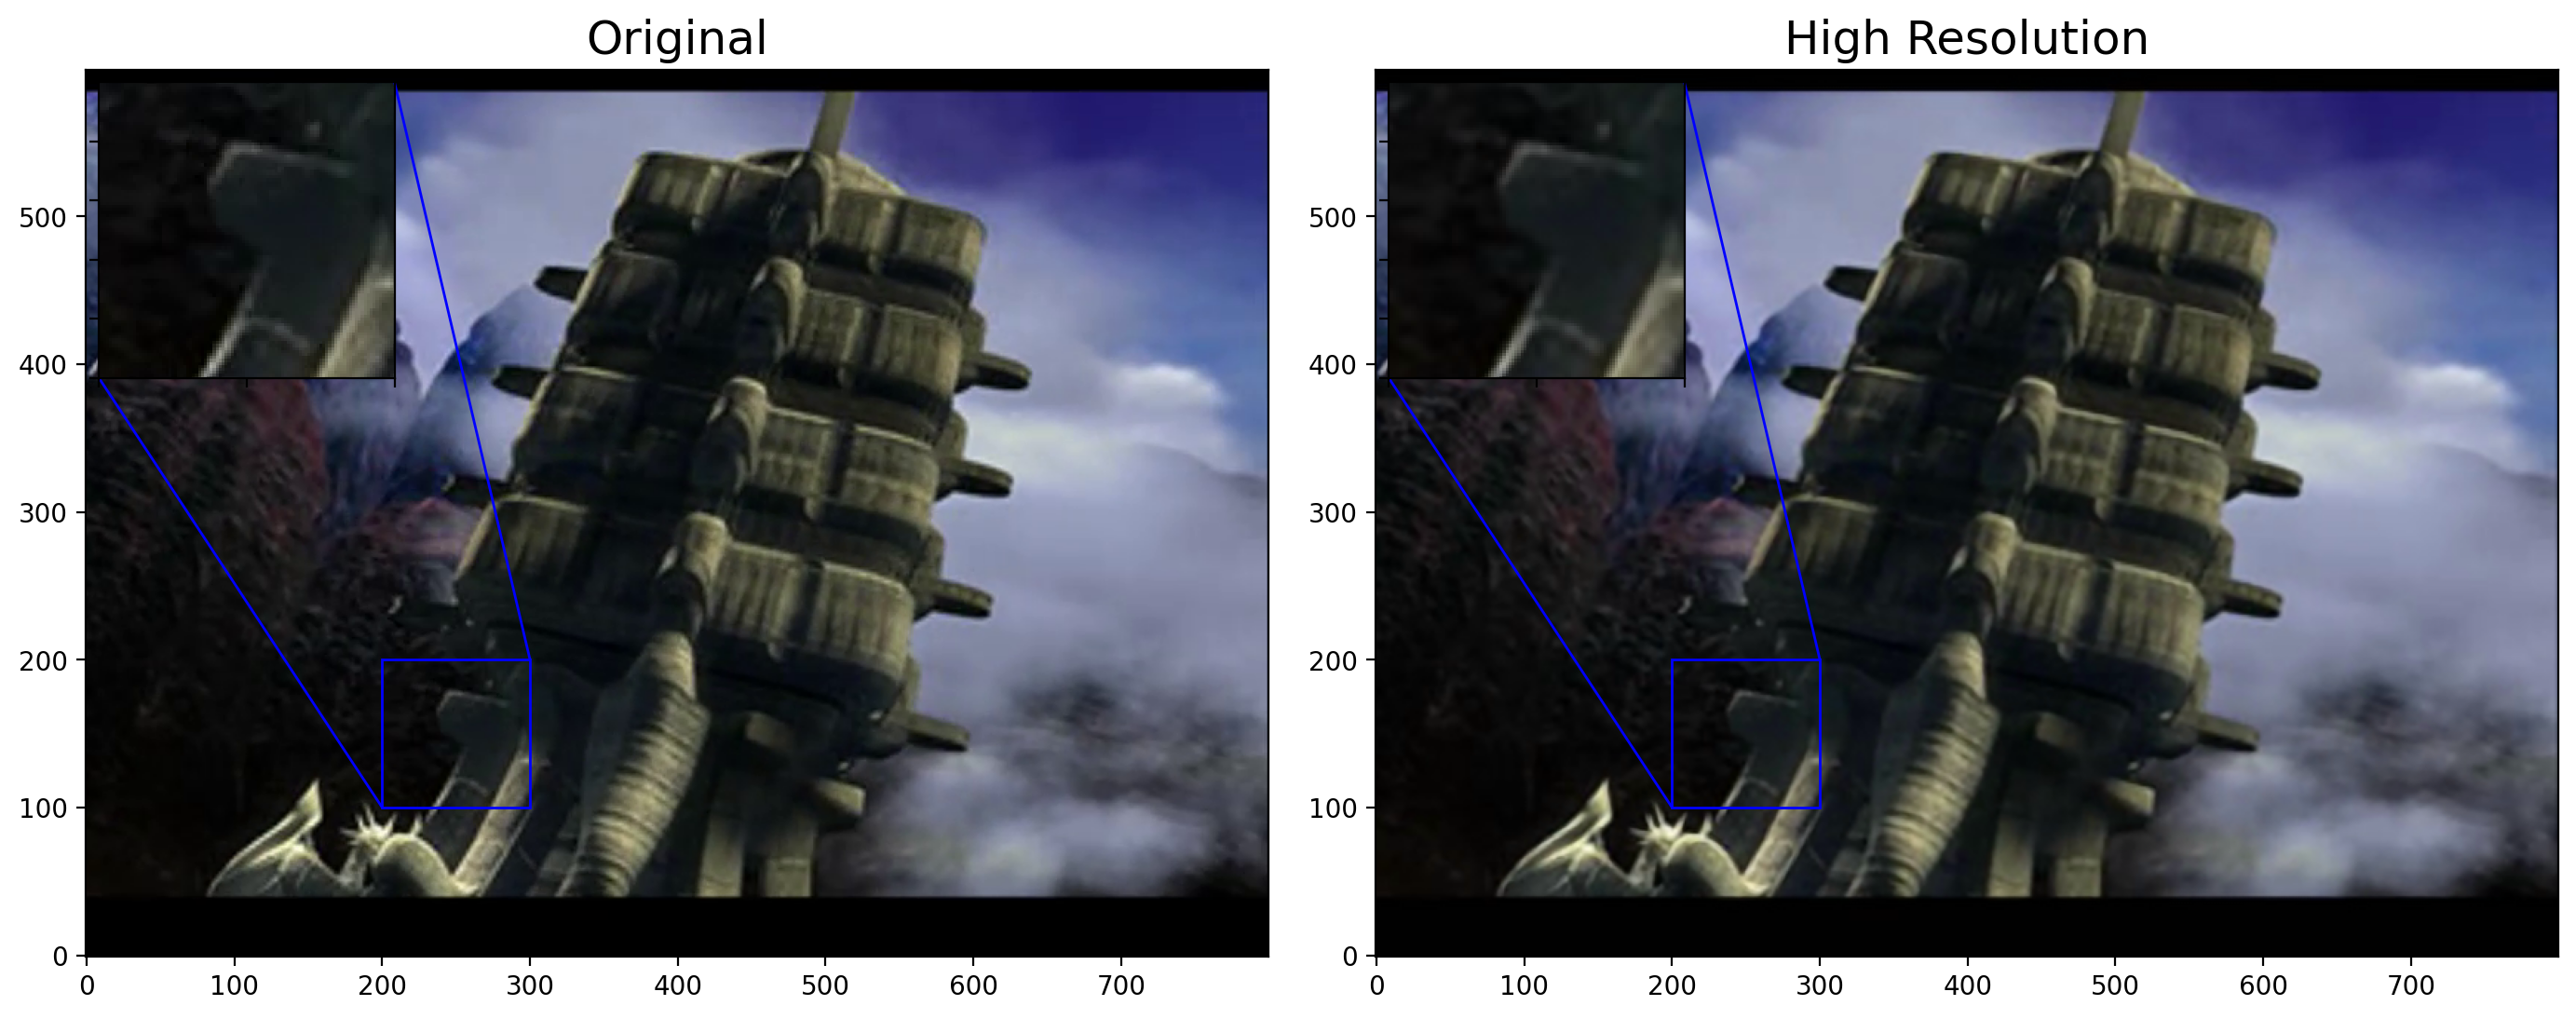

Can't read frame 2
Avg. PSNR of low resolution images is 	12.6687
Avg. PSNR of ESPCN reconstruction is 	12.6107
Avg. SSIM of low resolution images is 	0.4198
Avg. SSIM of ESPCN reconstruction is 	0.4135


In [6]:
# Test the whole video
test_super_resolution(original_video_path, remaster_video_path, test_video=True, learning_based_model='ESPCN')